In [34]:
# %load prelude.py
import numpy as np

import pandas as pd
import pandas_datareader as pd_reader
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import register_matplotlib_converters
import requests_cache
import matplotlib.dates as mdates

import cufflinks as cf
cf.go_offline()

cf.set_config_file(theme='space')


############################## PRELUDE ##############################

# initiate converters
register_matplotlib_converters()

# rc config
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = "bold"
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['axes.titleweight'] = "bold"
plt.rcParams['legend.fontsize'] = 14
plt.rcParams["lines.linewidth"] = 5.0
plt.style.use('dark_background')

expire_after = datetime.timedelta(hours=12)
session = requests_cache.CachedSession(
    cache_name='cache', backend='sqlite', expire_after=expire_after)

start = datetime.datetime(1990, 6, 1)
end = datetime.date.today()


def fred_reader(symbol, start=start):
    return pd_reader.data.DataReader(symbol, 'fred', start, end, session=session)


def fred_reader_series(symbol, start=start):
    return pd_reader.data.DataReader(symbol, 'fred', start, end, session=session)[symbol]


def fred_reader_multi(d, start=start):
    for (name, fred_name) in d.items():
        d[name] = fred_reader_series(fred_name, start)
    return pd.DataFrame(d).dropna()

# forward fill time series with last valid value


def fill(s):
    first, last = s.index[0], s.index[-1]
    rs = s.reindex(pd.date_range(first, last), method='ffill')
    return rs


def yahoo_reader(symbol, start=start):
    return pd_reader.data.DataReader(symbol, "yahoo", start, end, session=session)


def draw_span(ax, begin, end, leftmost, color='tab:grey', alpha=0.3):
    if begin > leftmost:
        ax.axvspan(begin, end, color=color, alpha=alpha)


def plot_recession(ax, leftmost):
    try:
        recs = fred_reader('USREC', start=datetime.datetime(
            1920, 1, 1)).query('USREC==1')
        recs_90 = recs.loc['1990':'1991']
        recs90_bgn = recs_90.index[0]
        recs90_end = recs_90.index[-1]
        draw_span(ax, recs90_bgn, recs90_end, leftmost)
        recs_2k = recs.loc['2001']
        recs2k_bgn = recs_2k.index[0]
        recs2k_end = recs_2k.index[-1]
        draw_span(ax, recs2k_bgn, recs2k_end, leftmost)
        recs_2k8 = recs.loc['2008':]
        recs2k8_bgn = recs_2k8.index[0]
        recs2k8_end = recs_2k8.index[-1]
        draw_span(ax, recs2k8_bgn, recs2k8_end, leftmost)
        plt.text(0, -0.15, "Shaded areas indicate US recessions",
                 horizontalalignment='left',
                 verticalalignment='center',
                 fontsize=14,
                 transform=ax.transAxes)
    except Exception as e:
        print(e)
        pass


def plot_qe(ax, leftmost):
    # Plot QE periods based on https://www.yardeni.com/chronology-of-feds-quantitative-easing/
    try:
        qe1_start = datetime.datetime(2008, 11, 25)
        qe1_end = datetime.datetime(2010, 5, 31)
        draw_span(ax, qe1_start, qe1_end, leftmost,
                  color='tab:orange', alpha=0.3)
        qe2_start = datetime.datetime(2010, 11, 3)
        qe2_end = datetime.datetime(2011, 9, 21)
        draw_span(ax, qe2_start, qe2_end, leftmost,
                  color='tab:orange', alpha=0.3)
        twist_start = datetime.datetime(2011, 9, 21)
        twist_end = datetime.datetime(2012, 6, 29)
        draw_span(ax, twist_start, twist_end, leftmost,
                  color='tab:olive', alpha=0.3)
        qe3_start = datetime.datetime(2012, 9, 13)
        qe3_end = datetime.datetime(2013, 12, 18)
        draw_span(ax, qe3_start, qe3_end, leftmost,
                  color='tab:orange', alpha=0.3)
        taper_start = datetime.datetime(2013, 12, 18)
        taper_end = datetime.datetime(2014, 10, 29)
        draw_span(ax, taper_start, taper_end, leftmost,
                  color='tab:pink', alpha=0.3)
        plt.text(0, -0.20, "Shaded color areas indicate Fed QE program - QE(orange), Twist(olive), Taper(pink)",
                 horizontalalignment='left',
                 verticalalignment='center',
                 fontsize=14,
                 transform=ax.transAxes)
    except Exception as e:
        print(e)
        pass


def add_source(ax, source):
    plt.text(0, -0.1, 'Source: ' + source,
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=14,
             transform=ax.transAxes)
    current_time = time.strftime("%m-%d-%Y %T %Z", time.localtime(time.time()))
    plt.text(1.0, -0.1, 'Date: ' + current_time,
             horizontalalignment='right',
             verticalalignment='center',
             fontsize=14,
             transform=ax.transAxes)
    current_year = time.strftime("%Y", time.localtime(time.time()))
    plt.text(1.0, -0.15, "Copyright © 2019 - " + current_year + " Bateman Capital",
             horizontalalignment='right',
             verticalalignment='center',
             fontsize=14,
             transform=ax.transAxes)


In [35]:
df = fred_reader_multi({
    'trade_deficit': 'BOPGSTB',
    'gov_deficit': 'MTSDS133FMS'
})
df.insert(0, 'twin_deficit', df.trade_deficit + df.gov_deficit)

In [36]:
twi_start_date = datetime.datetime(1992, 12, 1)
twi_dollar_major = fred_reader_series('DTWEXM')[twi_start_date:]
dxy = yahoo_reader('DX-Y.NYB').Close[twi_start_date:]

qdf = df.resample('Q').sum()
# normalize to million and align time with deficit data
billion_to_million = 1_000_000_000 / 1_000_000
qgdp = fred_reader('GDP').shift(3, 'M').GDP * billion_to_million
# Quarterly reading, Seasonally Adjusted Annual Rate
qdf.insert(0, 'quarterly_annual_GDP', qgdp)
qdf = qdf.dropna()
qdf.insert(2, 'twin_deficit_annual_adjusted', qdf.twin_deficit.rolling(4).sum())
qdf.insert(2, 'twin_deficit_pct_GDP', qdf.twin_deficit_annual_adjusted / qdf.quarterly_annual_GDP * 100.0)
qdf = qdf.dropna()

In [37]:
qdf

,quarterly_annual_GDP,twin_deficit,twin_deficit_pct_GDP,twin_deficit_annual_adjusted,trade_deficit,gov_deficit
DATE,,,,,,
1992-12-31,6680803.0,-133556.0,-5.481362,-366199.0,-13091.0,-120465
1993-03-31,6729459.0,-76899.0,-4.785526,-322040.0,-14244.0,-62655
1993-06-30,6808939.0,-35790.0,-4.693683,-319590.0,-17743.0,-18047
1993-09-30,6882098.0,-73132.0,-4.640692,-319377.0,-18994.0,-54138
1993-12-31,7013738.0,-110837.0,-4.229670,-296658.0,-19329.0,-91508
...,...,...,...,...,...,...
2019-06-30,21329877.0,-208150.0,-7.160421,-1527309.0,-152210.0,-55940
2019-09-30,21540325.0,-386930.0,-7.381207,-1589936.0,-149658.0,-237272
2019-12-31,21747394.0,-486351.0,-7.352187,-1598909.0,-129759.0,-356592


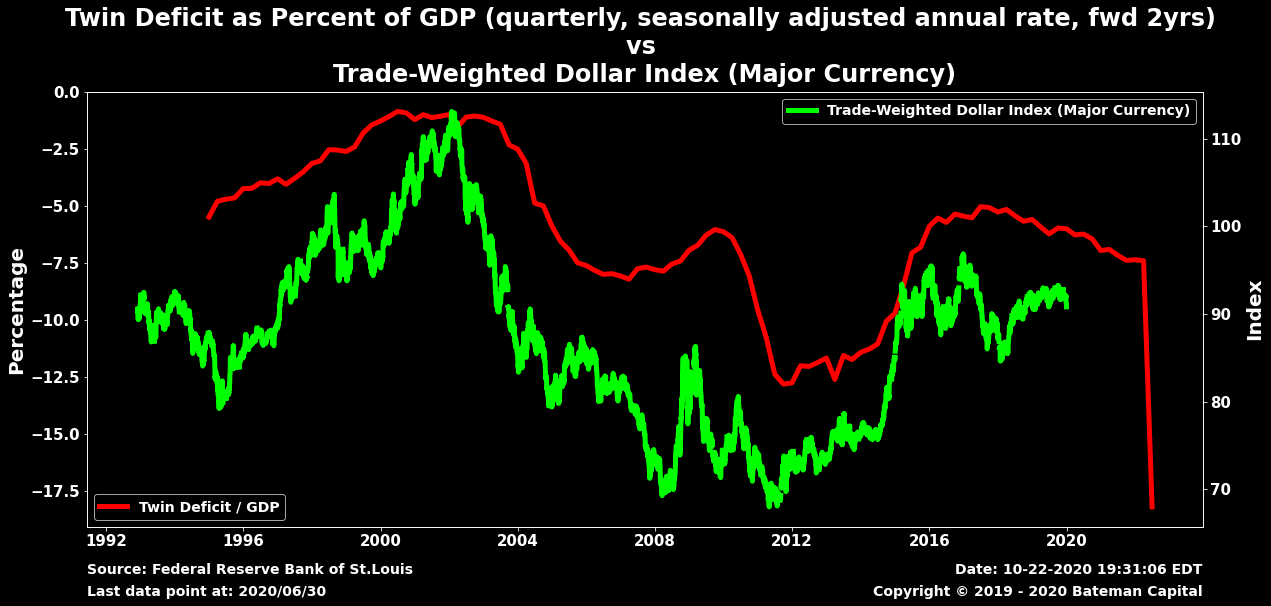

In [38]:
def plot_deficit_vs_dollar(dollar, dollar_label):
    fig, ax = plt.subplots()
    # forward 2 years
    ax.plot(qdf.twin_deficit_pct_GDP.shift(8, freq='Q'), label='Twin Deficit / GDP', color='red')
    ax.legend(loc='lower left')
    ax.set_ylabel('Percentage')
    ax2 = ax.twinx()
    ax2.plot(dollar,
             label=dollar_label,
             color='lime')
    ax2.set_ylabel('Index')
    ax2.legend(loc='upper right')
    add_source(ax, 'Federal Reserve Bank of St.Louis')
    plt.title('Twin Deficit as Percent of GDP (quarterly, seasonally adjusted annual rate, fwd 2yrs) \nvs \n{}'.format(dollar_label))
    last = qdf.index[-1]
    plt.text(0, -0.15, 'Last data point at: ' + last.strftime('%Y/%m/%d'),
          horizontalalignment='left',
          verticalalignment='center',
          fontsize=14,
          transform = ax.transAxes)

plot_deficit_vs_dollar(twi_dollar_major, 'Trade-Weighted Dollar Index (Major Currency)')

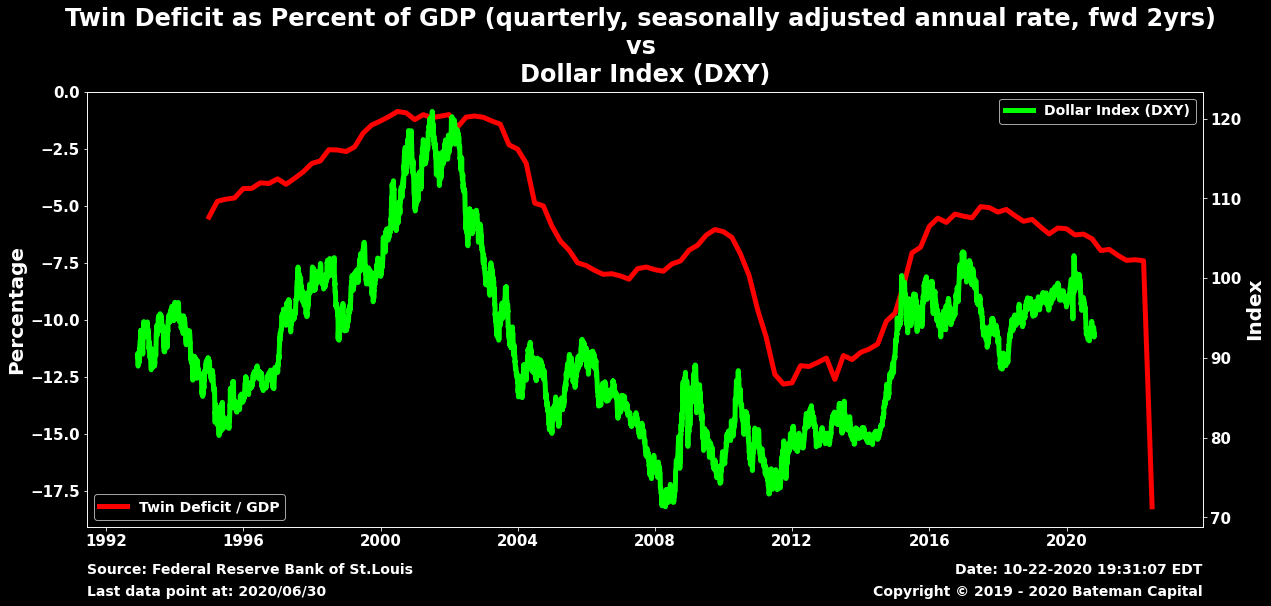

In [39]:
plot_deficit_vs_dollar(dxy, 'Dollar Index (DXY)')

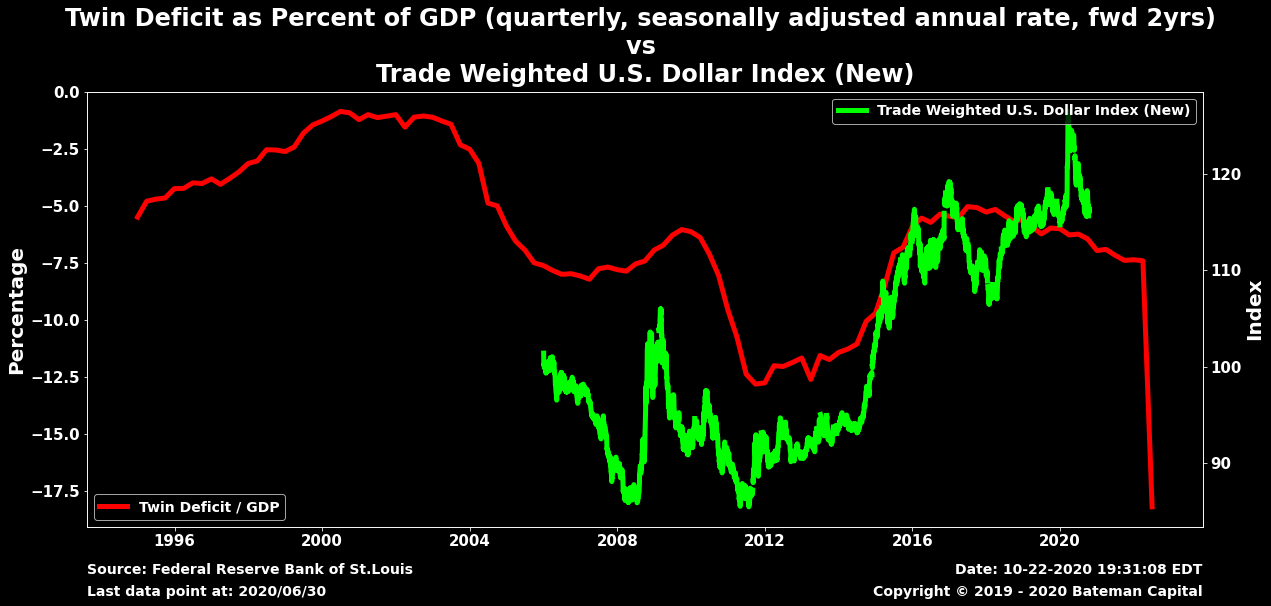

In [40]:
twi_new = fred_reader_series('DTWEXBGS')
plot_deficit_vs_dollar(twi_new, 'Trade Weighted U.S. Dollar Index (New)')

In [41]:
# https://www.cbo.gov/publication/56516
long_term = pd.read_csv('cbo_sep_2020_long_term_deficit_estimate.csv', index_col=0, parse_dates=True).shift(12 ,'M')

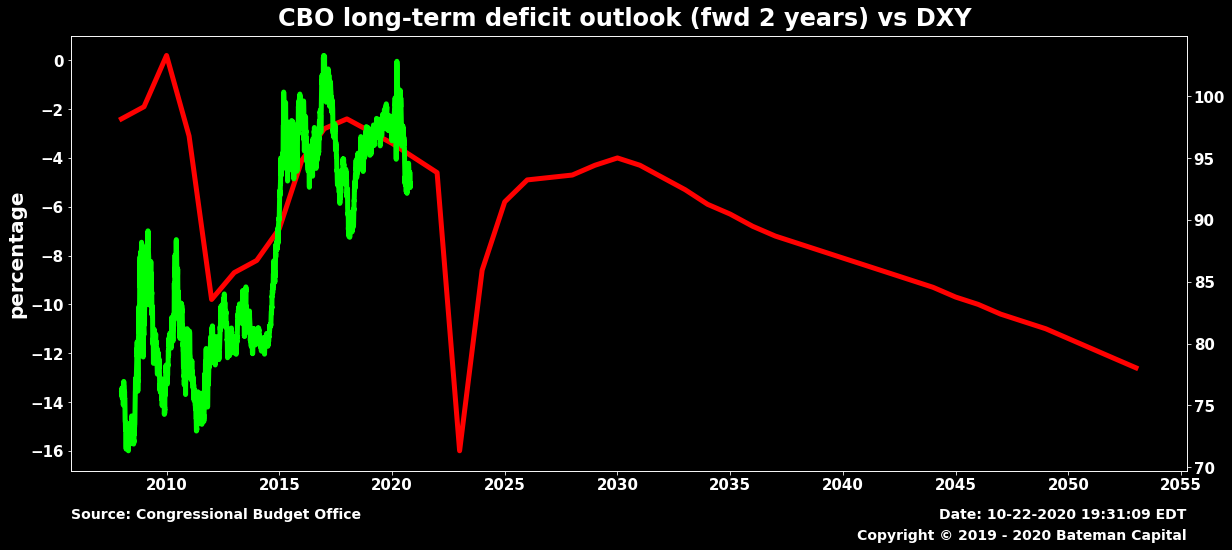

In [42]:
fig, ax = plt.subplots()
ax.plot(long_term.deficit.shift(2, 'Y'), label='CBO estimated deficit', color='red')
ax.set_ylabel('percentage')
ax2 = ax.twinx()
ax2.plot(dxy[datetime.datetime(2008, 1, 1):], color='lime')
plt.title('CBO long-term deficit outlook (fwd 2 years) vs DXY ')
add_source(ax, 'Congressional Budget Office')

In [43]:
def compare_twi(s):
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.plot(twi_new, label='TWI', color='lime')
    ax.set_ylabel('Index')
    ax2 = ax.twinx()
    ax2.set_ylabel('$')
    sp = yahoo_reader(s).Close[twi_new.index[0]:]
    sn = '$' + s
    ax2.plot(sp, label=sn)
    plt.title('Trade-weighted Dollar Index (inverted) vs {}'.format(sn))
    add_source(ax, 'Yahoo Finance, Federal Reserve Bank of St.Louis')
    ax2.legend(loc='upper right')

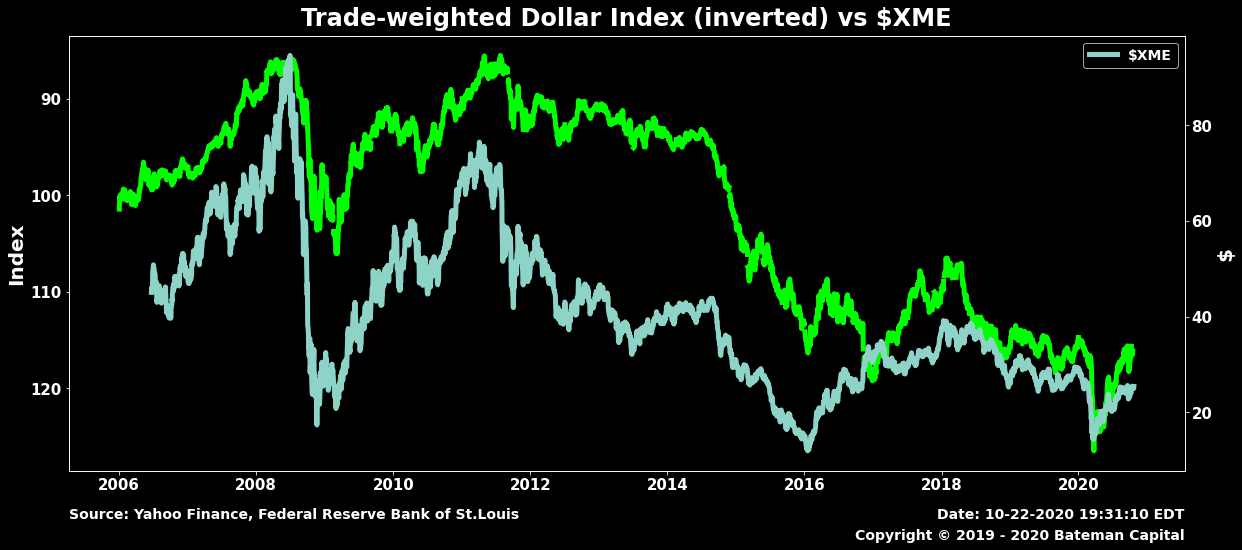

In [44]:
compare_twi('XME')

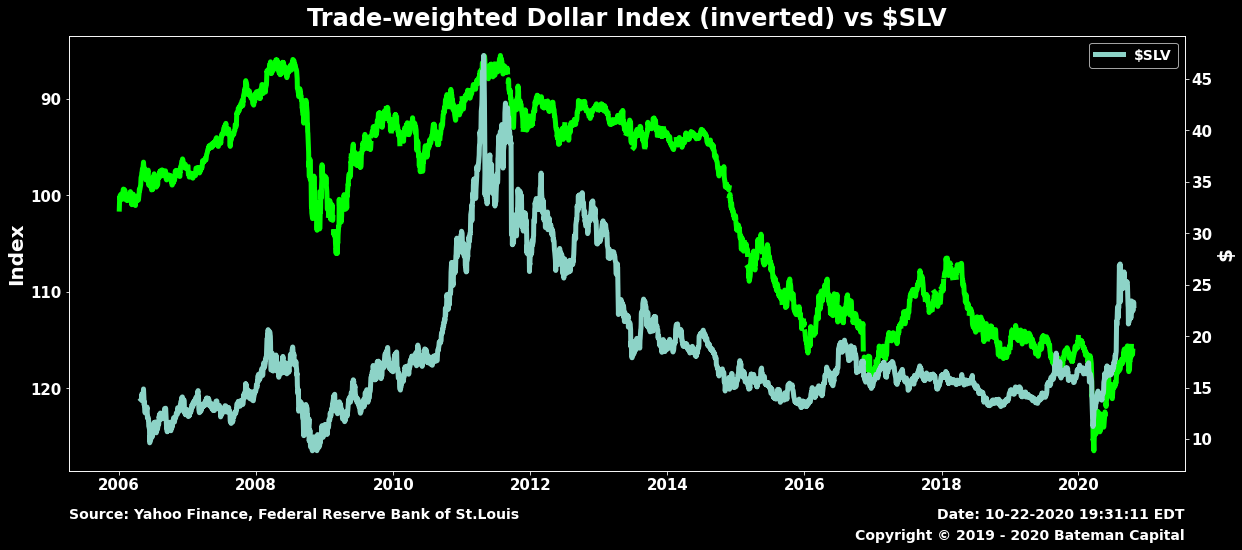

In [45]:
compare_twi('SLV')

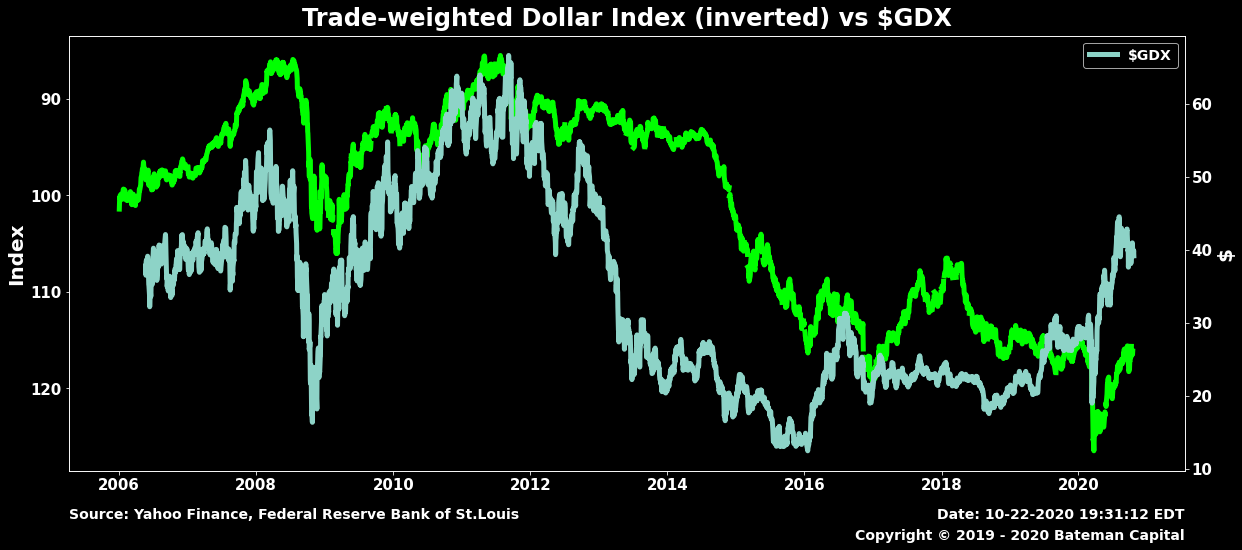

In [46]:
compare_twi('GDX')

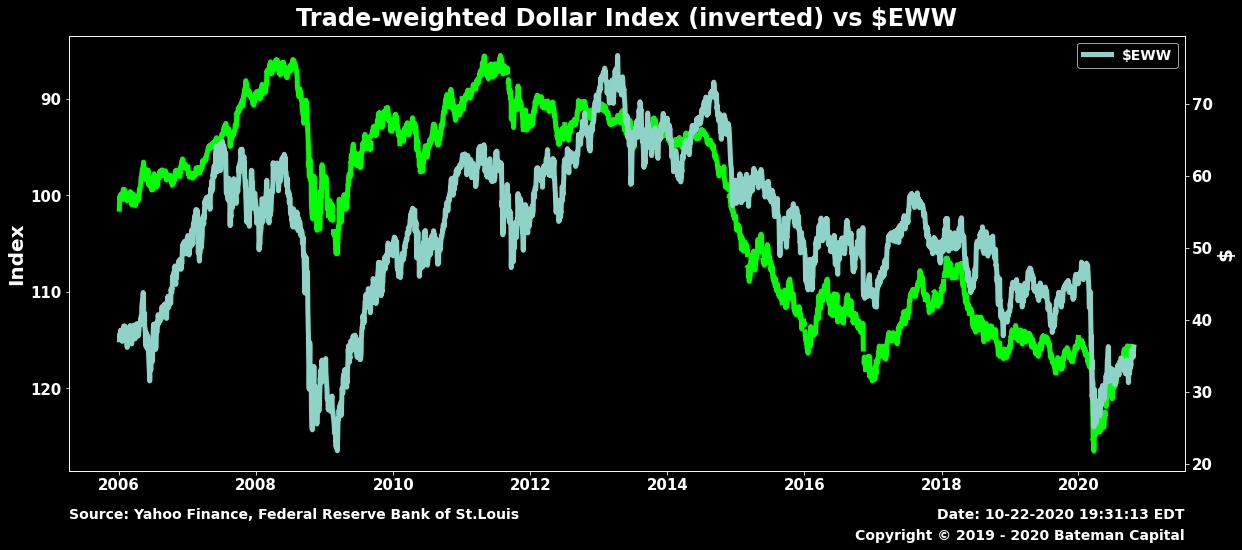

In [47]:
compare_twi('EWW')

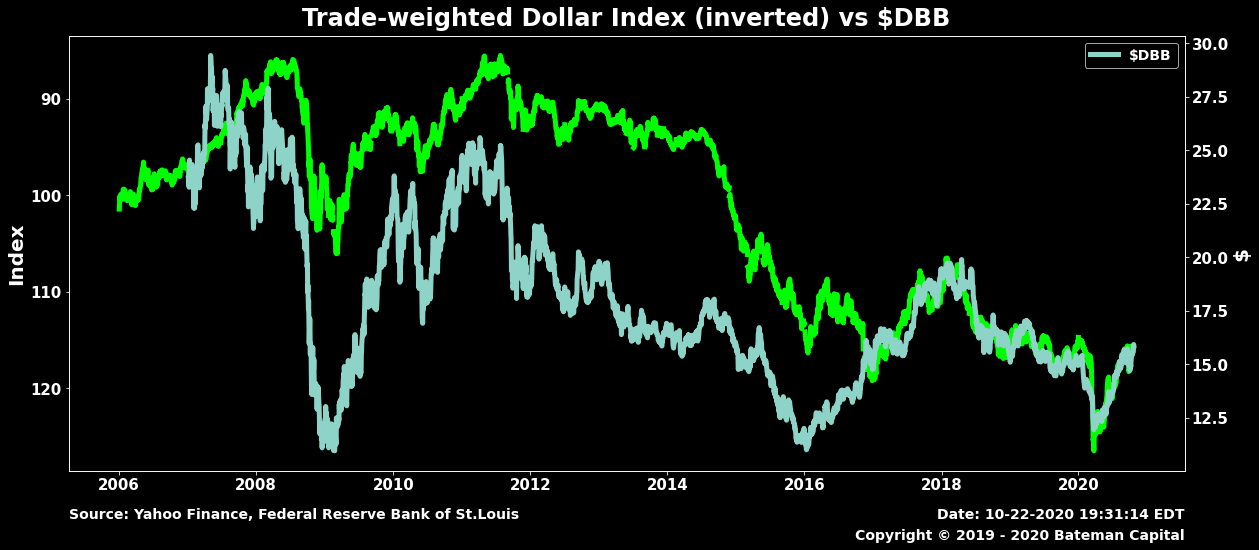

In [48]:
compare_twi('DBB')

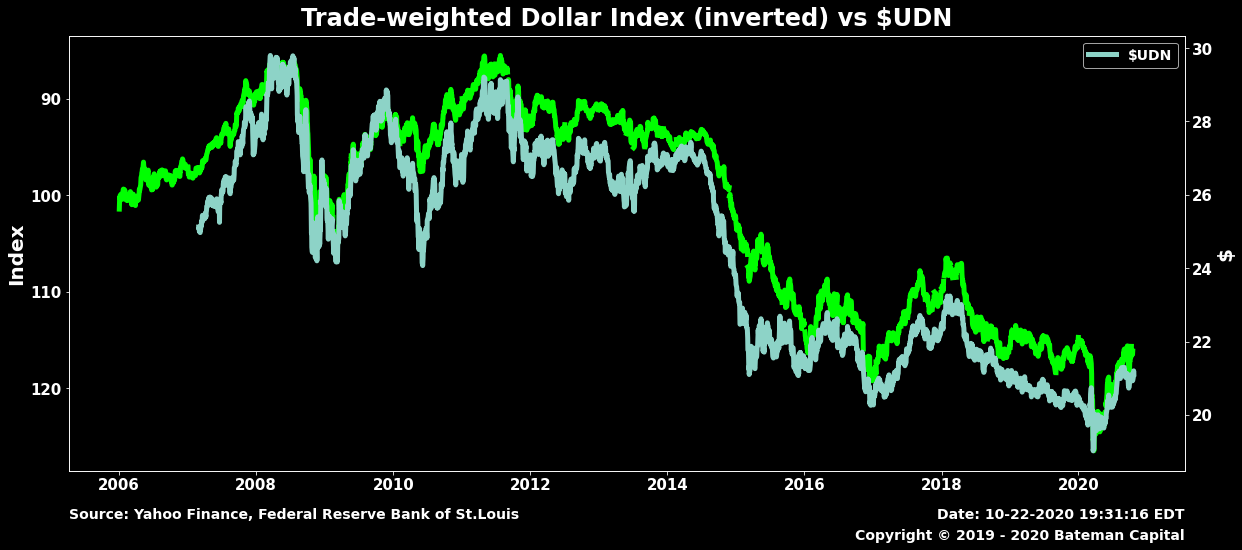

In [49]:
compare_twi('UDN')

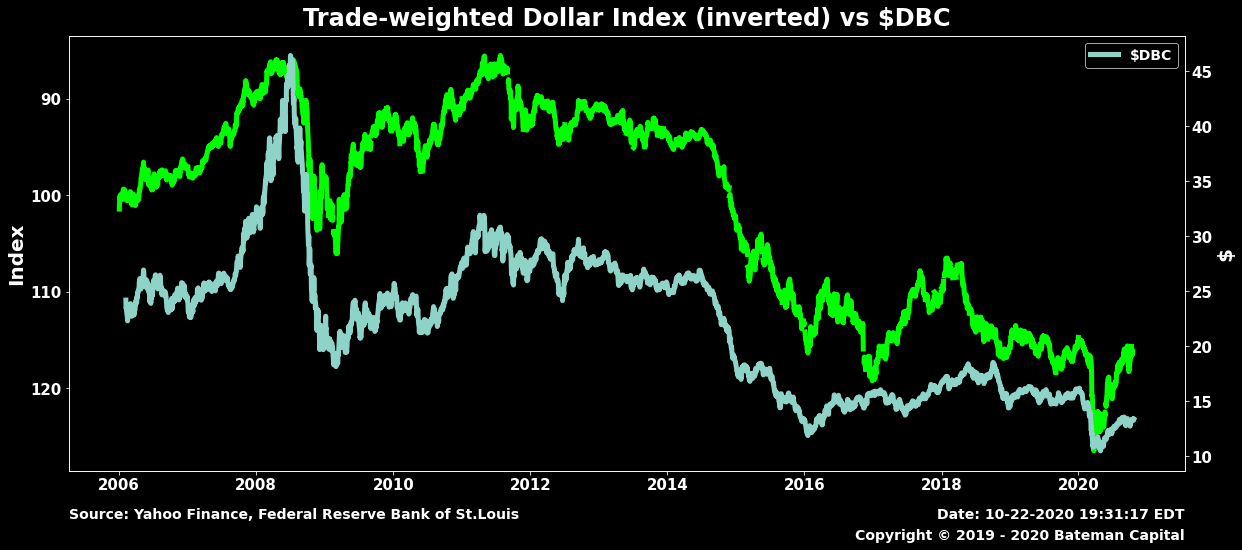

In [50]:
compare_twi('DBC')